# 38.2.2 Ultimate Inc.

## Part 1

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# load data
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# confirm that data was loaded as datetime object
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [7]:
# Set login time as index and start count
logins = logins.set_index('login_time')
logins['count'] = 1

In [8]:
# Resample to count logins per 15 minutes
logins_15 = logins.resample('15min').sum()
logins_15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


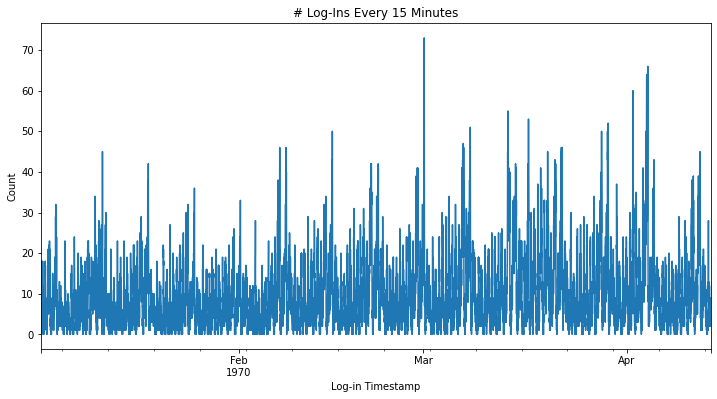

In [9]:
# Initial plot to get a sense of the data
logins_15.plot(legend = None, figsize = (12, 6))
plt.ylabel('Count')
plt.xlabel('Log-in Timestamp')
plt.title('# Log-Ins Every 15 Minutes')
plt.show()

In [10]:
logins_15.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


In [11]:
def differencer(data, t):
    diff = list()
    for i in range(len(data.index) - t):
        t2 = data.index[i]
        t1 = data.index[i + t]
        val = data.loc[t1, 'count'] - data.loc[t2, 'count']
        diff.append(val)
    return(diff)  

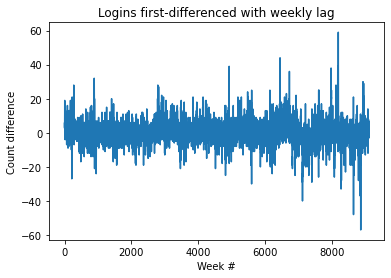

In [12]:
t = 4*24*7 # weekly
diffsWeekly = differencer(logins_15, t)

plt.plot(diffsWeekly)
plt.title('Logins first-differenced with weekly lag')
plt.ylabel('Count difference')
plt.xlabel('Week #')
plt.show()

The initial plot seemed like it exhibited a weekly pattern. Using one week as the lag period for differencing, we can see that this does seem to remove quite a bit of the seasonality from the original dataset. 

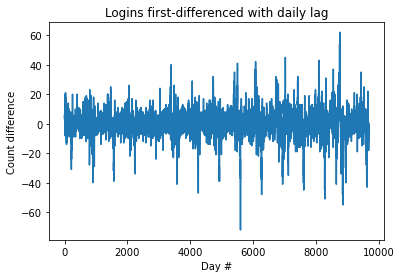

In [13]:
t = 4* 24
diffsDaily = differencer(logins_15, t)

plt.plot(diffsDaily)
plt.title('Logins first-differenced with daily lag')
plt.ylabel('Count difference')
plt.xlabel('Day #')
plt.show()

Using each day as the lag period seems to account for a lot of seasonality as well, although we are still seeing more spikes and regular patterns than in the differenced weekly set. Next, let's identify days of the week or times of day that are seeing particular high (or low) demand.

In [14]:
# Impact of the day of the week
daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
logins_dayofweek = logins_15.groupby(logins_15.index.dayofweek).mean()
logins_dayofweek['day'] = daysofweek
logins_dayofweek = logins_dayofweek.set_index('day', drop = True)
logins_dayofweek

,count
day,
Monday,6.213380
Tuesday,6.895833
Wednesday,7.692708
Thursday,8.794118
Friday,10.561111
Saturday,13.456250
Sunday,12.615972


More logins are happening during the weekends, increasing throughout the week before dropping on Monday.

In [15]:
# Impact of time of day
logins_time = logins_15.groupby([logins_15.index.dayofweek, logins_15.index.hour]).mean()
logins_time.index.names = ['day', 'hour']
logins_top3hrs = logins_time.groupby('day')['count'].nlargest(3, keep = 'all')
logins_top3hrs = logins_top3hrs.index.droplevel(level = 0)
logins_top3hrs = logins_top3hrs.set_levels(daysofweek, level = 'day')
logins_top3hrs

MultiIndex([(   'Monday', 11),
            (   'Monday', 12),
            (   'Monday', 22),
            (  'Tuesday', 11),
            (  'Tuesday', 22),
            (  'Tuesday', 23),
            ('Wednesday', 11),
            ('Wednesday', 23),
            ('Wednesday', 22),
            ( 'Thursday', 11),
            ( 'Thursday', 22),
            ( 'Thursday', 23),
            (   'Friday', 22),
            (   'Friday', 23),
            (   'Friday', 21),
            ( 'Saturday',  4),
            ( 'Saturday',  2),
            ( 'Saturday',  3),
            (   'Sunday',  4),
            (   'Sunday',  3),
            (   'Sunday',  2)],
           names=['day', 'hour'])

The above shows the 3 hours per day of the week that average the most logins. It looks like there is a marked difference between weekdays and weekends. During the week, there are two spikes: one around lunchtime (11 am - 1 pm) and one in the late evening (10 pm - 12 am). Meanwhile, Saturdays and Sundays see the greatest number of logins in the afternoon, between 2 - 5 p.m.

## Part 2

<b> Prompt:</b> <br>
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success.
<p></p>
<b> Response:</b><br>
1. Choosing a metric of success will be dicated primarily by the logistics of data collection; I want the most direct readout that I can accurately and reproducibly measure. Here, depending on what the existing numbers look like for these metrics (to give me a sense of where I could expect to reliably see a change if it occurred) I would likely choose either the number of drivers that have registered rides in both cities with three days (or other time period that make sense with the data) or the average proportion of rides in one city versus the other per driver.
2. Select a subset of drivers; the group should be large enough to give results that would be convincing to the stakeholders and ideally representative across characteristics that may impact results (e.g. city of residence or income levels). If feasible, can use entirety of driver partners and randomly distributed into two groups (experimental and control), ensuring that both groups are representative across potentially convoluting characteristics. Otherwise, group chosen is the experimental group and the remainder of driver partners can be used as control. Distribute information about the program to the experimental group in multiple ways that are thought to successfully reach the majority of drivers. Then collect data over a predetermined period of time (initial proposal 3 months, but should be decided using historical data of similar studies), then evaluate the experimental group relative to the control group using null hypothesis testing to determine if the intervention was likely to have had an impact on the chosen metric.

## Part 3

<b> Prompt: </b> Use these data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

In [30]:
# Data Import
retentionDF = pd.read_json('ultimate_data_challenge.json')
retentionDF.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [31]:
retentionDF.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [32]:
retentionDF.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [33]:
# Closer look at object types
retentionDF[['city', 'phone']].describe()

,city,phone
count,50000,49604
unique,3,2
top,Winterfell,iPhone
freq,23336,34582


In [34]:
# Data cleanup - dtype adjustment, null value filling, one hot encoding of categorical variables

retentionDF['last_trip_date'] = pd.to_datetime(retentionDF['last_trip_date'])
retentionDF['signup_date'] = pd.to_datetime(retentionDF['signup_date'])

retentionDF.loc[retentionDF['phone'].isna(), 'phone'] = 'Other'
retentionDF[['avg_rating_of_driver', 'avg_rating_by_driver']] = retentionDF[['avg_rating_of_driver', 'avg_rating_by_driver']]\
.fillna(retentionDF[['avg_rating_of_driver', 'avg_rating_by_driver']].mean())

retentionDF = pd.get_dummies(retentionDF, columns = ['city', 'phone'])

print("Data types:")
print(retentionDF.dtypes)
print("Nulls per columns:")
print(retentionDF.isna().sum())

Data types:
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
city_Astapor                        bool
city_King's Landing                 bool
city_Winterfell                     bool
phone_Android                       bool
phone_Other                         bool
phone_iPhone                        bool
dtype: object
Nulls per columns:
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
city_Astapor       

Data look clean! Now let's classify as Active or not, based on whether riders have taken a ride in the last month of data collection.

In [35]:
retentionDF['last_trip_date'].describe()

count                            50000
mean     2014-04-19 08:02:04.992000256
min                2014-01-01 00:00:00
25%                2014-02-14 00:00:00
50%                2014-05-08 00:00:00
75%                2014-06-18 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [36]:
# Classify riders active in the last month as "Active"
retentionDF['Active'] = np.where(retentionDF['last_trip_date'] >= '2014-06-01', 1, 0)

Now we will try to fitting with a Random Forest Classifier. This should give us a good idea of which features might important and won't require scaling between the different columns.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [41]:
y = retentionDF['Active']
X = retentionDF.drop(['Active', 'last_trip_date', 'signup_date'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

rcf = RandomForestClassifier()
rcf.fit(X_train, y_train)
predictions = rcf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))

Accuracy: 0.7532
Precision: 0.6741865509761388


In [44]:
featureImport = pd.DataFrame({'Feature': X.columns, 'Importance': rcf.feature_importances_})
featureImport.sort_values('Importance', ascending=False)

,Feature,Importance
6,avg_dist,0.299060
5,weekday_pct,0.134042
7,avg_rating_by_driver,0.110589
3,surge_pct,0.082220
1,avg_rating_of_driver,0.082085
0,trips_in_first_30_days,0.078501
2,avg_surge,0.068868
9,city_King's Landing,0.049118
4,ultimate_black_user,0.030279
11,phone_Android,0.019282


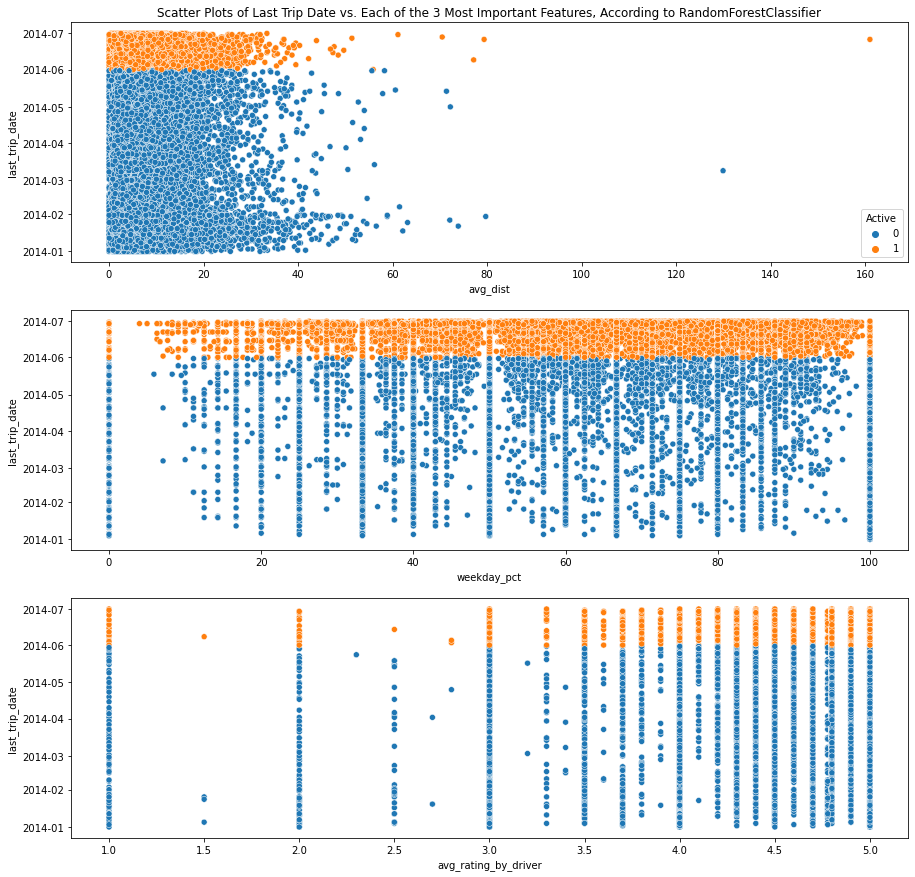

In [58]:
figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (15, 15))
ax1.set_title('Scatter Plots of Last Trip Date vs. Each of the 3 Most Important Features, According to RandomForestClassifier')
sns.scatterplot(data = retentionDF, x = 'avg_dist', y = 'last_trip_date', hue = 'Active', ax = ax1)
sns.scatterplot(data = retentionDF, x = 'weekday_pct', y = 'last_trip_date', hue = 'Active', ax = ax2, legend=False)
sns.scatterplot(data = retentionDF, x = 'avg_rating_by_driver', y = 'last_trip_date', hue = 'Active', ax = ax3, legend = False)
plt.show()

Although the model performs not-horribly, if we look at the plots above we see that whatever patterns and distinctions the model is identifying do not seem to be particularly meaningful. The "active" orange band seems to pull evenly from the top of the graph with no trend apparent based on the x-value in any of the panels. It does not appear as if there is a simple trend to be pulled out of these data with regards to which users are retained and which aren't.
<p>
To see if there is any more understanding we can glean about customers that might help inform potential avenues for the business to the explore, we can take a step back and see how all of the features correlate with being active or not.
</p>

In [67]:
retentionDF.corr()['Active'].sort_values(ascending=False)

Active                    1.000000
last_trip_date            0.780837
city_King's Landing       0.262284
phone_iPhone              0.225244
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
phone_Other              -0.007419
avg_rating_of_driver     -0.010829
signup_date              -0.020211
avg_rating_by_driver     -0.026748
city_Winterfell          -0.046611
avg_dist                 -0.092780
city_Astapor             -0.174655
phone_Android            -0.225464
Name: Active, dtype: float64

In [82]:
corrcat = ["city_King's Landing", "phone_iPhone", "trips_in_first_30_days", "ultimate_black_user"]

X = retentionDF[corrcat]

X_train, X_test, y_train, y_test = train_test_split(X, y)

rcf = RandomForestClassifier()
rcf.fit(X_train, y_train)
predictions = rcf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print("Precision:",metrics.precision_score(y_test, predictions))


Accuracy: 0.72408
Precision: 0.6778393351800553


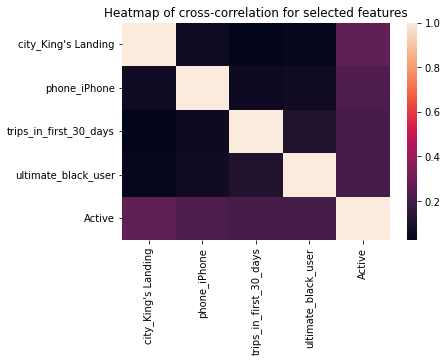

In [87]:
corrDF = retentionDF[corrcat + ['Active']]
sns.heatmap(corrDF.corr())
plt.title('Heatmap of cross-correlation for selected features')
plt.show()

There are no strong indicators pointing towards which members will be retained and which won't. There were a few features indicating weak correlation that may point towards potential areas for intervention. It seems like users joining in King's Landing and/or using an iPhone are more likely to be retained. Are there business or logistical reasons why that might be true? For example, is the iPhone version of the app significantly better or less glitchy than the Android app? Are there a lot of more drivers in King's Landing than in some of the surrounding cities? These could be areas to investigate to improve retention.<p>
There was also a weak correlation with number of trips taken in the first 30 days and involvement in the Ultimate Black program; it's possible that additional incentives to encourage users towards one or both of those areas would increase retention as well.<p>
Finally, additional data could be collected by reaching out to those customers that were not retained and asking them for their reasons. This should be a short (3 questions or less) survey or simply a request to e-mail back free-form feedback to increase likelihood of response. While the responses would not be coming from a representative sample, they would likely be coming from those customers who would most like to be using the service and aren't due to a specific complaint or logistic issue and thus more likely to be able to be enticed back.